In [1]:
import numpy as np 
import pandas as pd 

import os
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam
from torch import nn

from sklearn.metrics import classification_report
from torch.utils.data import random_split

%matplotlib inline

! pip install -q imutils
from imutils import paths
import shutil
from urllib.request import urlopen
from PIL import Image

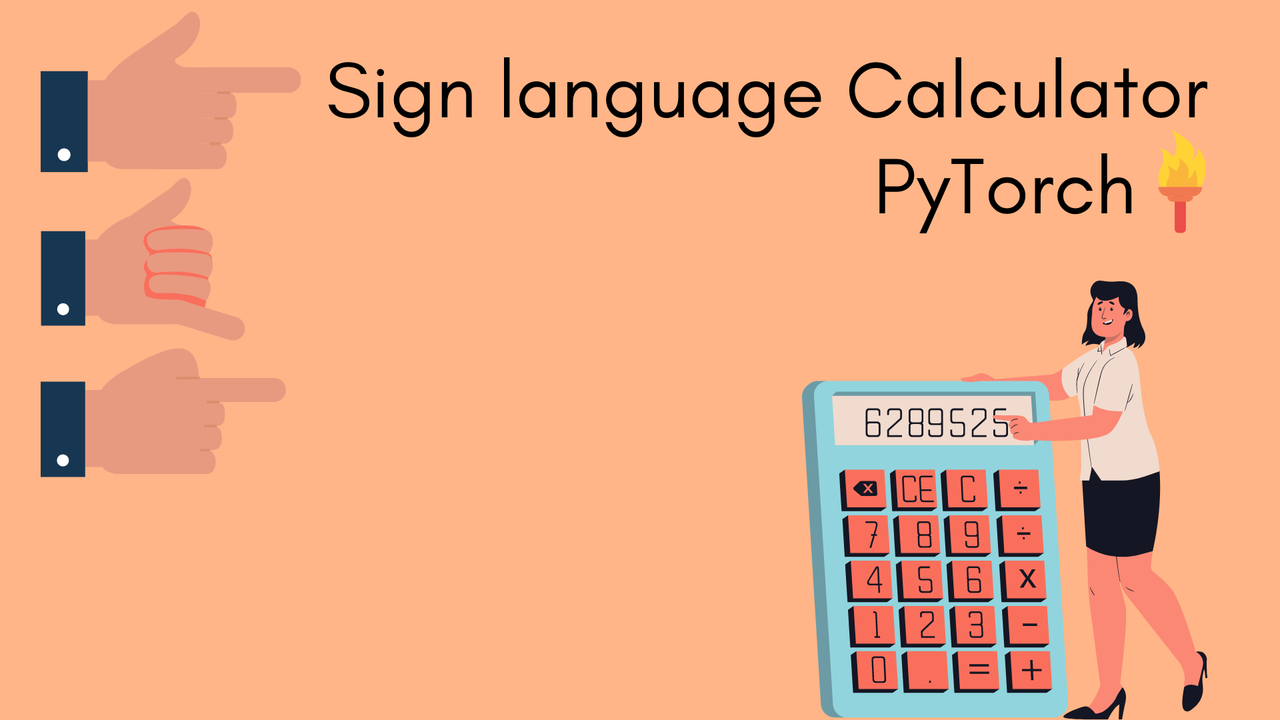

In [2]:
mmm = Image.open(urlopen("https://i.postimg.cc/zf4JqghM/fooled-by-the-accuracy.png"))
mmm

# 1. Loading and Visualizing data

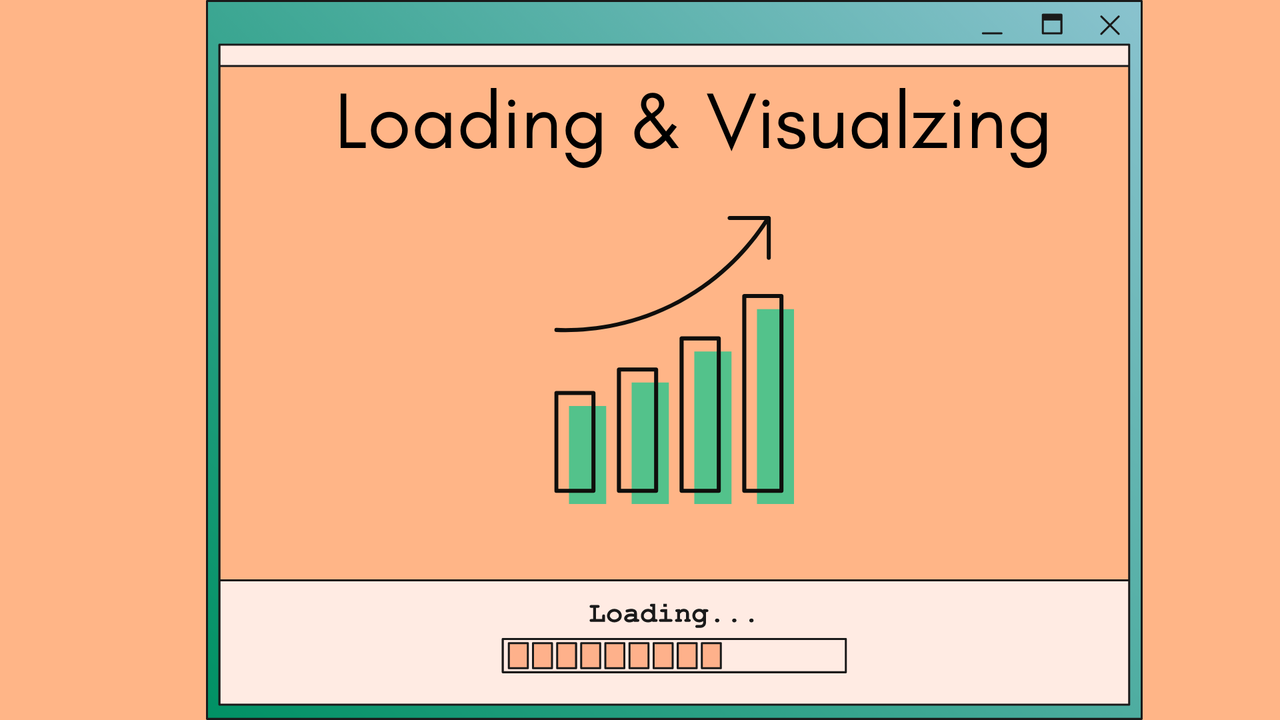

In [3]:
mmm = Image.open(urlopen("https://i.postimg.cc/ZnBpC3sd/fooled-by-the-accuracy-1.png"))
mmm

In [4]:
# Initializing parameters 

PATH = '/kaggle/input/asl-dataset/asl_dataset/asl_dataset'

INPUT_HEIGHT = 28
INPUT_WIDTH  = 28

TRAIN = "train"
VAL = "val"

BATCH_SIZE = 8
VAL_SPLIT  = 0.15
EPOCHS = 50
LR = 1e-3


In [5]:
def copy_images(imagePaths, folder):
    
    # Creating destination folder
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    # loop over the image paths
    for path in imagePaths:
        # Fetching name and label if the image and saving the files in training and validation folders
        imageName = path.split('/')[-1]
        label = path.split('/')[-2]
        labelFolder = os.path.join(folder, label)
        
        # Creating labelfolder if it doesn't exits
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)
            
        # construct the destination image path and copy the current image to it
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)

In [6]:
# load all the image paths and randomly shuffle them

print(">>> Loading Image paths...\n")

imagePaths = list(paths.list_images(PATH))
np.random.shuffle(imagePaths)

# Generating train & val paths

valPathsLen = int(len(imagePaths) * VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen

trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

# Copying the training and validation images to their respective directories using the function above

print(">>> Copying training and validation images...")
copy_images(trainPaths, TRAIN)
copy_images(valPaths, VAL)

>>> Loading Image paths...

>>> Copying training and validation images...


In [7]:
def visualize_batch(batch, classes, dataset_type):
    
    fig = plt.figure("{} batch".format(dataset_type), figsize=(BATCH_SIZE, BATCH_SIZE))
    
    # Looping over the batch size
    for i in range(0, BATCH_SIZE):
        
        # Creating a subplot
        ax = plt.subplot(int(BATCH_SIZE/4), int(BATCH_SIZE/2), i + 1)
        
        '''grab the image, convert it from channels first ordering to
        channels last ordering, and scale the raw pixel intensities
        to the range [0, 255]'''
        
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]
        
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
        
    # show the plot
    plt.tight_layout()
    plt.show()

In [8]:
# Initializing our transformations & augmentations

resize = transforms.Resize(size=(INPUT_HEIGHT, INPUT_WIDTH))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

In [9]:
# Initializing our training and validation set data augmentation pipeline

trainTransforms = transforms.Compose([resize, hFlip, vFlip, rotate, transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

In [10]:
# initialize the training and validation dataset

print(">>> Loading the training and validation dataset...\n")

trainDataset = ImageFolder(root = TRAIN, transform = trainTransforms)
valDataset = ImageFolder(root = VAL, transform = valTransforms)

print(">>> Training dataset contains {} samples...".format(len(trainDataset)))
print(">>> Validation dataset contains {} samples...".format(len(valDataset)))

>>> Loading the training and validation dataset...

>>> Training dataset contains 2138 samples...
>>> Validation dataset contains 377 samples...


In [11]:
# create training and validation set dataloaders

print(">>> Creating training and validation set dataloaders...")

trainDataLoader = DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size = BATCH_SIZE)

>>> Creating training and validation set dataloaders...


>>> Visualizing training and validation batch...


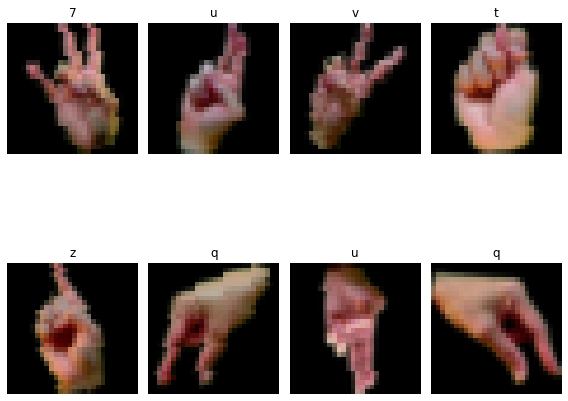

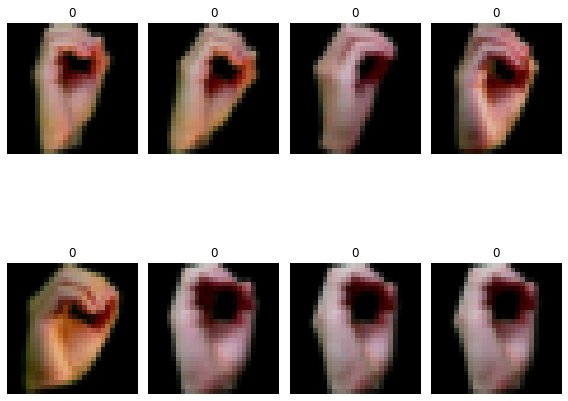

In [12]:
# Fetching a batch from both training and validation dataloader

trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

# visualize the training and validation set batches using visualize_batch function defined above

print(">>> Visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

# 2. Training Model

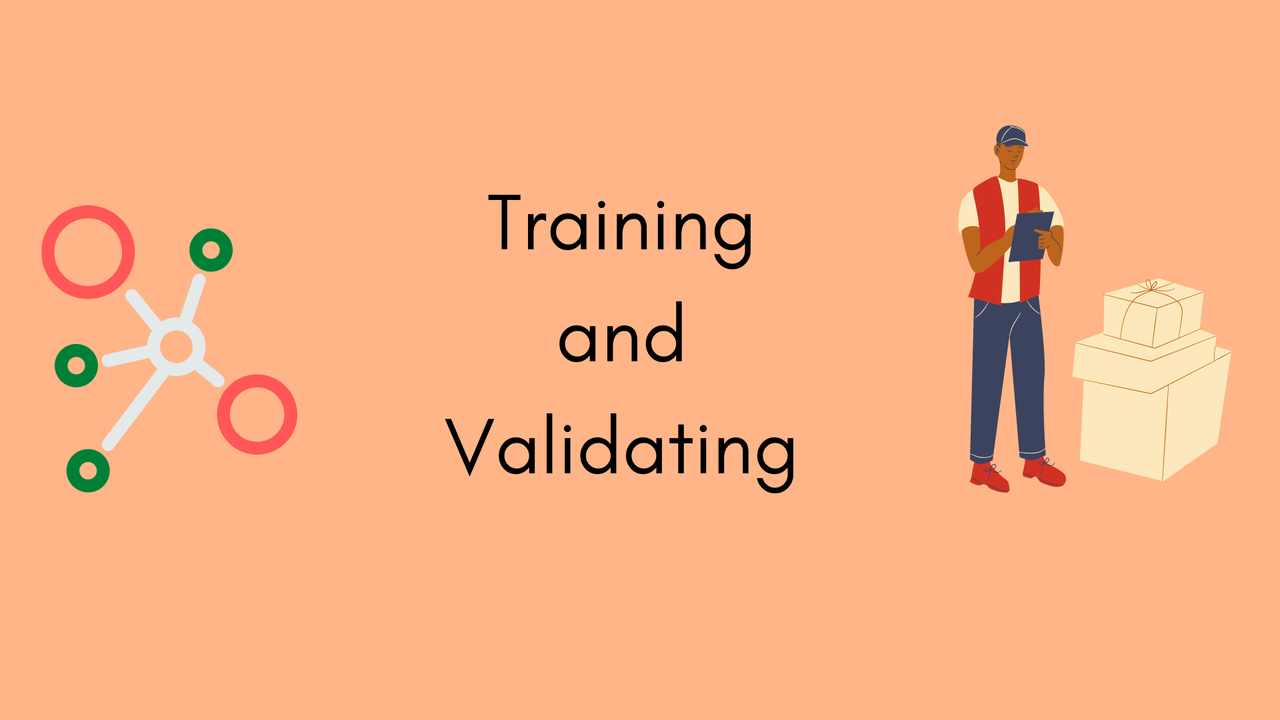

In [13]:
mmm = Image.open(urlopen("https://i.postimg.cc/fTvY2xSM/fooled-by-the-accuracy-2.png"))
mmm

In [14]:
# Steps per epoch 

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [15]:
class Net(Module):
    def __init__(self, numChannels, classes):
        super(Net, self).__init__()

        self.conv1 = Conv2d(in_channels=numChannels,
                            out_channels=20,
                            kernel_size=(5, 5))
        self.relu = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = Conv2d(in_channels=20,
                            out_channels=50,
                            kernel_size=(5, 5))      

        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = Linear(in_features=800, out_features=500)
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)

        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        output = self.logSoftmax(x)

        return output

In [16]:
print(">>> Initializing the  model...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(numChannels=3, classes=len(trainDataLoader.dataset.classes)).to(device)


opt = Adam(model.parameters(), lr=LR)
lossFn = nn.NLLLoss()

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
     }

print(">>> Training the network...")
startTime = time.time()

>>> Initializing the  model...
>>> Training the network...


In [17]:
for e in range(0, EPOCHS):
    
    # Training
    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    for (x, y) in trainDataLoader:

        (x, y) = (x.to(device), y.to(device))

        pred = model(x)
        loss = lossFn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    # Evaluation
    with torch.no_grad():

        model.eval()

        for (x, y) in valDataLoader:

            (x, y) = (x.to(device), y.to(device))

            pred = model(x)
            totalValLoss += lossFn(pred, y)

            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculating the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # Calculating the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset) # like correcct/total
    valCorrect = valCorrect / len(valDataLoader.dataset)
 
    # Updating training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
 
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

[INFO] EPOCH: 1/50
Train loss: 2.714447, Train accuracy: 0.2128
Val loss: 1.509756, Val accuracy: 0.4695

[INFO] EPOCH: 2/50
Train loss: 1.487265, Train accuracy: 0.5056
Val loss: 0.860387, Val accuracy: 0.7056

[INFO] EPOCH: 3/50
Train loss: 1.040187, Train accuracy: 0.6413
Val loss: 0.620402, Val accuracy: 0.7560

[INFO] EPOCH: 4/50
Train loss: 0.814107, Train accuracy: 0.7105
Val loss: 0.501265, Val accuracy: 0.8223

[INFO] EPOCH: 5/50
Train loss: 0.659669, Train accuracy: 0.7680
Val loss: 0.473125, Val accuracy: 0.8090

[INFO] EPOCH: 6/50
Train loss: 0.539846, Train accuracy: 0.8054
Val loss: 0.379776, Val accuracy: 0.8647

[INFO] EPOCH: 7/50
Train loss: 0.481602, Train accuracy: 0.8199
Val loss: 0.244597, Val accuracy: 0.9019

[INFO] EPOCH: 8/50
Train loss: 0.438739, Train accuracy: 0.8316
Val loss: 0.446046, Val accuracy: 0.8435

[INFO] EPOCH: 9/50
Train loss: 0.397405, Train accuracy: 0.8531
Val loss: 0.295323, Val accuracy: 0.8992

[INFO] EPOCH: 10/50
Train loss: 0.331194, Trai

### ^^ Expand output to see Epoch training

In [18]:
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Total time taken to train the model: 361.16s


In [19]:
H = pd.DataFrame(H)
H.head().style.applymap(lambda x : "background-color: #fadcb4")\
.set_table_styles([{'selector' : '', 'props' : [('border', '2px solid black')]}])

,train_loss,train_acc,val_loss,val_acc
0,2.7144465,0.212816,1.5097558,0.469496
1,1.487265,0.505613,0.8603873,0.705570
2,1.0401874,0.641254,0.6204016,0.755968
3,0.81410706,0.710477,0.5012648,0.822281
4,0.6596688,0.768007,0.47312504,0.809019


In [20]:
for col in H.columns:
    H[col] = H[col].astype('float64')

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = H.index,
                         y = H['train_loss'],
                         name = 'train_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#05ad24')))

fig.add_trace(go.Scatter(y = H['val_loss'],
                         x = H.index,
                         name = 'val_loss',
                         mode = 'lines',
                         line = dict(dash='dot'),
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['val_acc'],
                         x = H.index,
                         name = 'val_acc',
                         mode = 'lines',
                         marker =  dict(color = '#0688cf')))

fig.add_trace(go.Scatter(y = H['train_acc'],
                         x = H.index,
                         name = 'train_acc',
                         mode = 'lines',
                         marker =  dict(color = '#05ad24')))

fig.update_xaxes(title = '# Epoch',
        range = [0,51],
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = False,
        showgrid = False,
        ticks = 'outside')

fig.update_yaxes(title = 'Loss/Accuracy',
        tickfont = dict(size=15),
        tickmode = 'array',
        showline = False,
        showgrid = True,
        ticks = 'outside')

fig.update_layout(width=600,
                  title = dict(text = 'Training Loss and Accuracy on Dataset',
                               x = 0.5,
                               font = dict(size = 16, color ='#27302a',
                               family = 'monospace')),
                  plot_bgcolor='#fadcb4',
                  paper_bgcolor = '#fadcb4')

fig.show()

In [22]:
# To save the model
#torch.save(model, args["model"])

# 3. Simple Calculator

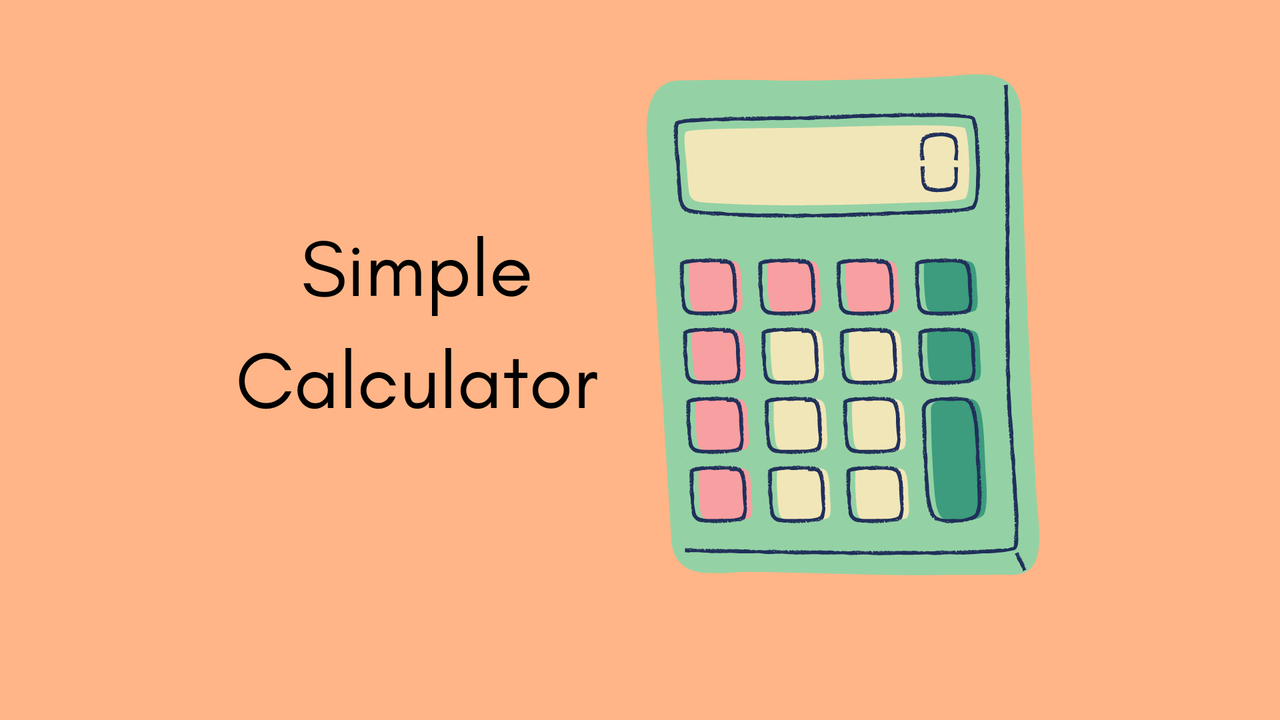

In [23]:
mmm = Image.open(urlopen("https://i.postimg.cc/Gm8Gc6Sm/fooled-by-the-accuracy-3.png"))
mmm

In [24]:
# Defining basic functions for later

calc = {
    '0':'0',
    '1':'1',
    '2':'2',
    '3':'3',
    '4':'4',
    '5':'5',
    '6':'6',
    '7':'7',
    '8':'8',
    '9':'9',    
    'a':'+',
    'c':')',
    'd':'/',
    'e':'**',
    'f':'//',
    'm':'*',
    'o':'(',
    'r':'%',
    's':'-'  
        }

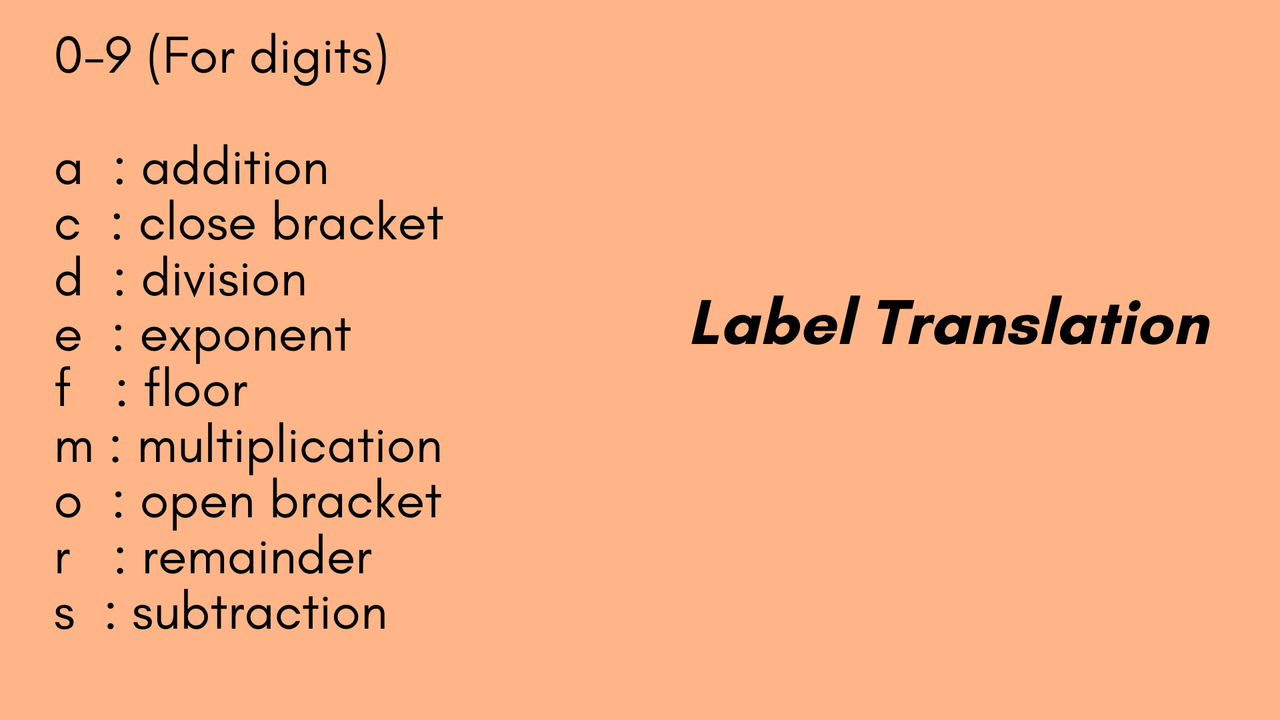

In [25]:
mmm = Image.open(urlopen("https://i.postimg.cc/SRR7cRVW/fooled-by-the-accuracy-4.png"))
mmm

In [26]:
# Expression '14 * 3 ** 3 + 4'

equation = [
trainDataset[71][0],
trainDataset[280][0],
trainDataset[1324][0],
trainDataset[220][0],
trainDataset[880][0],
trainDataset[220][0],
trainDataset[630][0],
trainDataset[280][0]
]

In [27]:
equation = torch.stack(equation)
predicted_equation = []

eqLoader = DataLoader(equation, batch_size = 1)

In [28]:
with torch.no_grad():

    for image in eqLoader:

        origImage = image.numpy()#.squeeze(axis=(0, 1))

        image = image.to(device)
        pred = model(image)

        idx = pred.argmax(axis=1).cpu().numpy()[0]
        predLabel = valDataLoader.dataset.classes[idx]
        predicted_equation.append(predLabel)

In [29]:
print('Predicted labels : ', predicted_equation)

for i in range(len(predicted_equation)):
    predicted_equation[i] = calc[str(predicted_equation[i])]
    
print('Modified labels : ', predicted_equation)
expression = ''.join(predicted_equation)
answer = eval(expression)

print('Calculation : ', answer)
print(14*3**3+4)

Predicted labels :  ['1', '4', 'm', '3', 'e', '3', 'a', '4']
Modified labels :  ['1', '4', '*', '3', '**', '3', '+', '4']
Calculation :  382
382


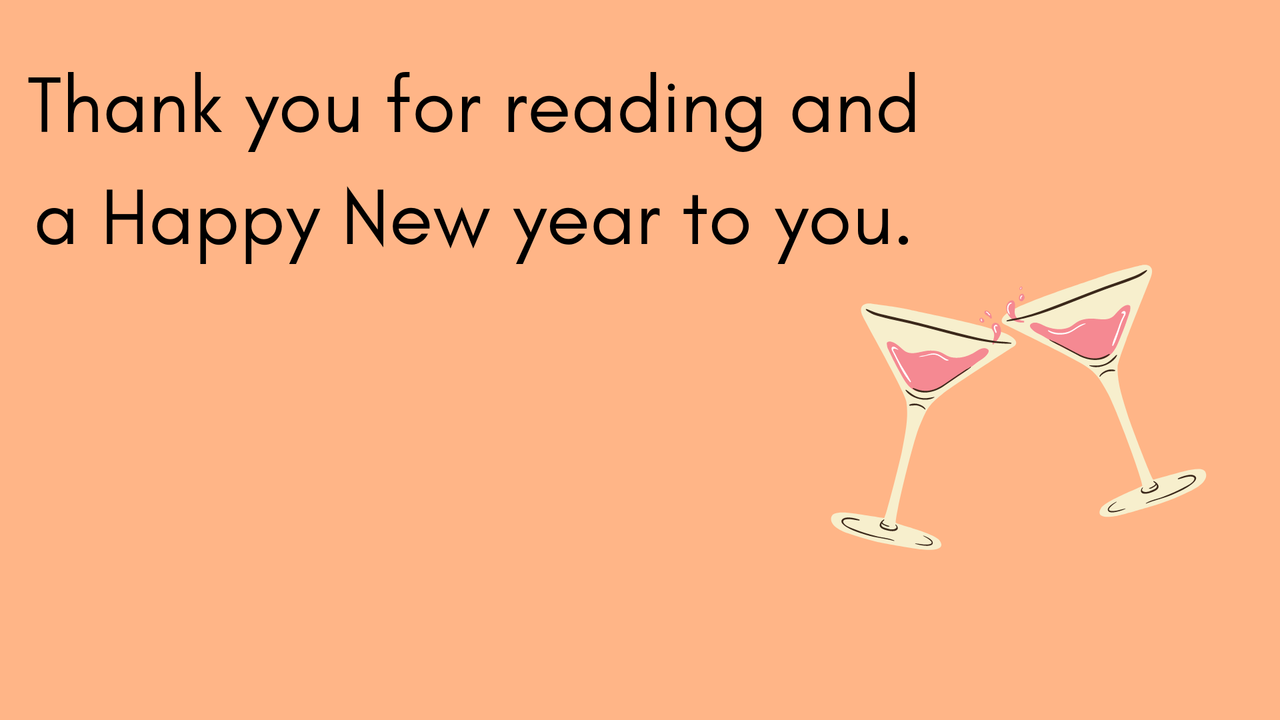

In [30]:
mmm = Image.open(urlopen("https://i.postimg.cc/Z5s9yH2D/fooled-by-the-accuracy-5.png"))
mmm

In [31]:
print ("ASL")

ASL
